In [124]:
from pathlib import Path
from tqdm import tqdm, tqdm_notebook

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt



import tensorflow as tf
from tensorflow import keras
from keras import Sequential

import keras
from keras.models import Sequential
from keras.layers import GRU, LSTM
import numpy as np

In [125]:
# put your own path to the data root directory (see example in `Data architecture` section)
data_dir = Path("..")

# load the training and testing data sets
train_features_dir = data_dir / "train_input" / "moco_features"
test_features_dir = data_dir / "test_input" / "moco_features"
df_train = pd.read_csv(data_dir  / "supplementary_data" / "train_metadata.csv")
df_test = pd.read_csv(data_dir  / "supplementary_data" / "test_metadata.csv")

# concatenate y_train and df_train
y_train = pd.read_csv(data_dir  / "train_output_76GDcgx.csv")
df_train = df_train.merge(y_train, on="Sample ID")

print(f"Training data dimensions: {df_train.shape}")  # (344, 4)
df_train.head()

Training data dimensions: (344, 4)


,Sample ID,Patient ID,Center ID,Target
0,ID_001.npy,P_001,C_1,0
1,ID_002.npy,P_002,C_2,1
2,ID_005.npy,P_005,C_5,0
3,ID_006.npy,P_006,C_5,0
4,ID_007.npy,P_007,C_2,1


In [126]:
X_train = []
y_train = []
centers_train = []
patients_train = []

for sample, label, center, patient in tqdm(
    df_train[["Sample ID", "Target", "Center ID", "Patient ID"]].values
):
    # load the coordinates and features (1000, 3+2048)
    _features = np.load(train_features_dir / sample)
    # get coordinates (zoom level, tile x-coord on the slide, tile y-coord on the slide)
    # and the MoCo V2 features
    coordinates, features = _features[:, :3], _features[:, 3:]  # Ks
    # slide-level averaging
    #X_train.append(np.mean(features, axis=0))
    
    X_train.append(features)
    y_train.append([label]*1000)
    centers_train.append(center)
    patients_train.append(patient)

# convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
centers_train = np.array(centers_train)
patients_train = np.array(patients_train)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 344/344 [00:02<00:00, 145.64it/s]


In [127]:

def reduce_y(y):
    y_reduced = list()
    for y_ in y:
        y_reduced.append(np.array([y_[0]]))
    return np.array(y_reduced)


def train_val_test_split(X, y, train_size=0.8, val_size=0.1, test_size=0.1, random_state=42):
    """
    Split the input data into training, testing, and validation sets
    Args:
        X: input data
        y: labels
        train_size: proportion of data to be used for training
        val_size: proportion of data to be used for validation
        test_size: proportion of data to be used for testing
        random_state: seed for random number generator
    Returns:
        X_train, X_val, X_test, y_train, y_val, y_test
    """
    np.random.seed(random_state)
    n_samples = X.shape[0]
    idx = np.random.permutation(n_samples)
    X, y = X[idx], y[idx]
    train_end = int(train_size * n_samples)
    val_end = int((train_size + val_size) * n_samples)
    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end:val_end], y[train_end:val_end]
    X_test, y_test = X[val_end:], y[val_end:]
    return X_train, X_val, X_test, reduce_y(y_train), reduce_y(y_val), reduce_y(y_test)

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X_train, y_train, train_size=0.8, val_size=.2, test_size=0)



In [128]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X_train, y_train, train_size=0.8, val_size=.2, test_size=0)


X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
y_train = y_train.float()



X_val = torch.from_numpy(X_val)
y_val = torch.from_numpy(y_val)
y_val = y_val.float()


X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)
y_test = y_test.float()

In [129]:
X_train.shape

torch.Size([275, 1000, 2048])

In [236]:
import torch
import torch.nn as nn

# Define input shape
input_shape = (1000, 2048)

# Create the GRU model
class GRUModel(nn.Module):
    def __init__(self):
        super(GRUModel, self).__init__()
        
        self.gru = nn.GRU(input_size=2048, hidden_size=64, num_layers=1)
        self.fc = nn.Linear(64, 1)
        self.dropout = nn.Dropout(p=0.4)
        #self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):

        x, _ = self.gru(x)
        x = x[:,-1,:]
        x = self.fc(x)
        x = self.dropout(x)
        #x = self.sigmoid(x)
        return x

# Initialize the model
model = GRUModel()

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)



In [237]:
from sklearn.metrics import roc_auc_score

In [238]:
y_train.shape

torch.Size([275, 1])

In [239]:

train_losses = []
val_losses = []
train_rocauc = []
val_rocauc = []

BATCH_SIZE = 16
EPOCHS = 30


# Training loop
for epoch in tqdm_notebook(range(EPOCHS)):
    print(f'======================== EPOCH - {epoch+1} ===========================')
    
    epoch_losses = []
    epoch_rocauc = []
    
    for i in range(0, len(X_train), BATCH_SIZE):
        X_batch = X_train[i:min(i + BATCH_SIZE, len(X_train))]
        y_batch = y_train[i:min(i + BATCH_SIZE, len(y_train))]
    
        # Forward pass
        output = model(X_batch)
        # Compute loss
        loss = criterion(output, y_batch)
        # Zero gradients
        optimizer.zero_grad()
        # Backward pass and update weights
        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())
        #epoch_rocauc.append(roc_auc_score(y_batch, (output > 0.5).long()))
    
    train_loss = np.mean(epoch_losses)
    #train_metric = np.mean(epoch_rocauc)
    
    print('\nTrain\n')
    print(f'Training Loss: {train_loss}')
        
    train_losses.append(train_loss)
    #train_rocauc.append(train_metric)
   # print(f'Train ROC AUC score: {train_score}')
    
    print('\nVal\n')
    with torch.no_grad():
        output = model(X_val)
        predicted = (output > 0.5).long()
        accuracy = (predicted == y_val).float().mean()
        #print(f'Validation Accuracy: {accuracy}')
        val_loss = criterion(output,y_val)
        print(f'Val loss : {val_loss.item()}')
        val_losses.append(val_loss.item())
        
        #######
    
        val_score = roc_auc_score(y_val, predicted)
        print(f'Val ROC AUC score: {val_score}')
        val_rocauc.append(val_score)
    


/var/folders/p8/_kjf3t992f18h9kf52z7snvw0000gn/T/ipykernel_23238/820428686.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(EPOCHS)):


  0%|          | 0/30 [00:00<?, ?it/s]

======================== EPOCH - 1 ===========================

Train

Training Loss: 0.6762237846851349

Val

Val loss : 0.7109693884849548
Val ROC AUC score: 0.5
======================== EPOCH - 2 ===========================

Train

Training Loss: 0.6639265285597907

Val

Val loss : 0.7329897880554199
Val ROC AUC score: 0.5
======================== EPOCH - 3 ===========================

Train

Training Loss: 0.6501944859822592

Val

Val loss : 0.7301231622695923
Val ROC AUC score: 0.5
======================== EPOCH - 4 ===========================

Train

Training Loss: 0.6541748344898224

Val

Val loss : 0.7123754620552063
Val ROC AUC score: 0.5
======================== EPOCH - 5 ===========================

Train

Training Loss: 0.6641916566424899

Val

Val loss : 0.7444041967391968
Val ROC AUC score: 0.5
======================== EPOCH - 6 ===========================

Train

Training Loss: 0.6478002534972297

Val

Val loss : 0.7398335337638855
Val ROC AUC score: 0.5
================

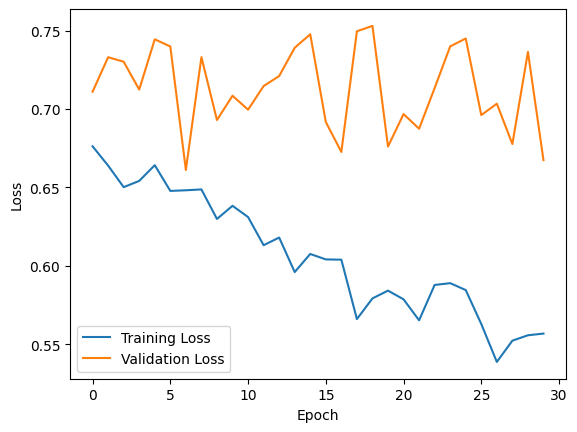

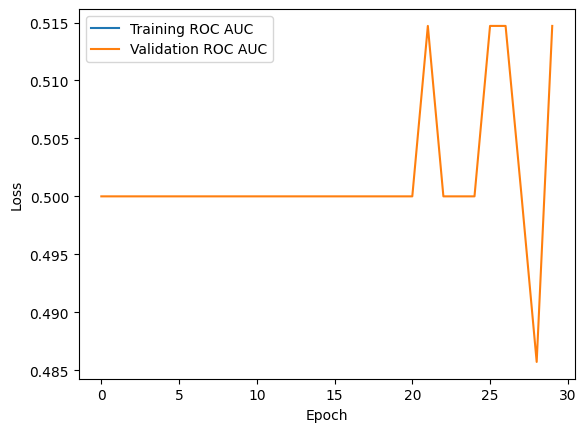

In [241]:
# Plot the training and validation loss curves
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy curves
plt.plot(train_rocauc, label='Training ROC AUC')
plt.plot(val_rocauc, label='Validation ROC AUC')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [98]:
X_test = []

# load the data from `df_test` (~ 1 minute)
for sample in tqdm(df_test["Sample ID"].values):
    _features = np.load(test_features_dir / sample)
    coordinates, features = _features[:, :3], _features[:, 3:]
    X_test.append(features)

X_test = np.array(X_test)
X_test = torch.from_numpy(X_test)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 271.81it/s]


In [99]:
# Evaluation
with torch.no_grad():
    output = model(X_test)
    predicted = (output > 0.5).long()
    accuracy = (predicted == y_test).float().mean()
    print(f'Accuracy: {accuracy}')

Accuracy: nan


In [100]:
preds_test = np.squeeze(model(X_test).detach().numpy())


In [101]:
preds_test.shape

(149,)

In [102]:
submission = pd.DataFrame(
    {"Sample ID": df_test["Sample ID"].values, "Target": preds_test}
).sort_values(
    "Sample ID"
)  # extra step to sort the sample IDs

# sanity checks
assert all(submission["Target"].between(0, 1)), "`Target` values must be in [0, 1]"
assert submission.shape == (149, 2), "Your submission file must be of shape (149, 2)"
assert list(submission.columns) == [
    "Sample ID",
    "Target",
], "Your submission file must have columns `Sample ID` and `Target`"

# save the submission as a csv file
submission.to_csv(data_dir / "benchmark_test_output.csv", index=None)
submission.head()

,Sample ID,Target
0,ID_003.npy,0.135344
1,ID_004.npy,0.091483
2,ID_008.npy,0.137148
3,ID_009.npy,0.088691
4,ID_010.npy,0.116247


In [243]:
X_train.shape

torch.Size([275, 1000, 2048])